
# 参考
https://qiita.com/mhangyo/items/76db7c6a6ebba6cf4330

dtypeに関する資料
http://discexuno.wp.xdomain.jp/machine-learning/python_fromfile_fromstring/
https://docs.python.org/3/library/struct.html

3Dfigure
https://morvanzhou.github.io/tutorials/data-manipulation/plt/3-5-3d/

時空間フィルタリング
https://home.hiroshima-u.ac.jp/kikuuwe/pub/05_acmtap.pdf
http://www.eeengblog.com/engineer/%E3%83%95%E3%83%BC%E3%83%AA%E3%82%A8%E5%A4%89%E6%8F%9B%E3%82%92%E4%BD%BF%E3%81%A3%E3%81%9F%E7%94%BB%E5%83%8F%E8%A7%A3%E6%9E%90



# 付録ーーデータの展開法

一つの実験についてのデータは四つのフォルダーに分けております。
そのうち、「Height」と書いてるフォルダーに変異データが入ってます。
そのフォルダーの中には縦方向（Y軸）の画素分のデータファイルがあります。
一つのファイルには一行についての画像枚分のデータが横方向（X軸）の画素分重ねております。

つまり、X行、Y棚、Fフレームのデータポイントを見つけるには
Y個目のファイルを開いて、X×フレーム数（16666frames=500fps×33.3s）＋F　のインデックスでXYFのデータがあります。

データ自体は64bit doubleです。バイトオーダーはビッグエンディアンです (byte order: big endian)。ヘッダーはないです。


他の設定に関する情報元(resolution/framerate/downsampling,etc)　　\\FS1\Maedalab\home\junjie-hua\wave\fourD_sensor\rawdata\20191101\Captures


f = open(r"\\FS1\Maedalab\home\junjie-hua\wave\fourD_sensor\rawdata\20191101\test1_belly\Height\Height Row 0000.data",mode='rb')#0列目
topo = np.fromfile(f, dtype='float64',sep='').reshape(256,20000) #float64の形で読み込むと，5120000の数列ができました．bellyの計測時間=20*1000msため，256*20000とreshapeしました．x軸上のサンプリング点が256個となります．


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2 
from scipy.fftpack import fft,ifft
import scipy.fftpack as sfft
import os
import glob
from pylab import *
import math
import matplotlib.animation as animation
from ipywidgets import IntProgress
from IPython.display import display

In [2]:
#path = "//FS1//Maedalab//home//junjie-hua//wave//fourD_sensor//rawdata//20191101//test1_belly//Height" #belly上の計測データ元　
path = "C://Users//huaju//Documents//data//fourD_sensor//20191101//test1_belly//Height" #belly上の計測データ元　

files = os.listdir(path) #all files in the faulder　縦方向(y軸)のデータファイル
s = []
ynum = 0

print("reading files")
#os.chdir("//FS1//Maedalab//home//junjie-hua//wave//fourD_sensor//rawdata//20191101//test1_belly//Height") #local()関数を利用するためのコードです
os.chdir("C://Users//huaju//Documents//data//fourD_sensor//20191101//test1_belly//Height") #local()関数を利用するためのコードです
for file in glob.glob("*.data"): 
    f = open(path + "//" + file ,mode='rb')#n列目　rb= read binary
    name = 'topo'+str(ynum)  #一つのファイルには一行についての画像枚分のデータが横方向（X軸）の画素分のデータを変数topo+str(n)に入れます
    locals()['topo'+str(ynum)]= np.fromfile(f, dtype='>d').reshape(256,20000) 
    # https://docs.python.org/3/library/struct.html
    # ">" means big endian, "d" means double. 5120000の数列ができました．bellyの計測時間=20*1000msため，256*20000とreshapeしました．x軸上のサンプリング点が256個となります．
    #print(file,"has ended")
    ynum = ynum + 1 

print("end reading")
print(ynum ,"y-axis files") #y軸上サンプリング点の数を数えます--252個
xnum = 256
T = 20000

reading files
end reading
252 y-axis files


In [3]:
# (x,y,t)のデータを取り出すための関数 
names = locals()
def f(x,y,t): 
    k = names['topo'+str(y)][x,t]  #topo_str(y)の数列から，(x,t)のデータを取り出します
    return k
#print(f(255,251,19999))


# X, Y value
x = np.linspace(0,xnum-1,xnum)
y = np.linspace(0,ynum-1,ynum)
X,Y = np.meshgrid(x,y)  #サンプリング点の数：x軸256個， y軸252個
#Z = [[0 for i in range(X.shape[1])] for i in range(Y.shape[0])] #Z--y行x列
Z = [[0 for row in range(xnum)] for col in range(ynum)]  #Z--x列y行    e.g. arr2D = [[ 0 for col in range(10) ] for row in range(4) ]-- 10列4行

## color map animation 

In [4]:
"""
print(" color map start")
for t in range(T):
    if t % 100 == 0:
        for y in range(ynum): #y axis
            for x in range(xnum): # x axis
                Z[y][x] = f(x,y,t)    
        Z_array = np.array(Z)# turn list into array
        
        #color mapを作成する
        #plt.pcolormesh(X, Y, Z_array, cmap='hsv') # 等高線図の生成。cmapで色付けの規則を指定する。
        plt.pcolormesh(X, Y, Z_array, cmap='jet') # 等高線図の生成。cmapで色付けの規則を指定する。


        pp=plt.colorbar (orientation="vertical") # カラーバーの表示 

        plt.xlabel('X', fontsize=18)
        plt.ylabel('Y', fontsize=18)
        plt.title("T = %s ms"% (t))

        #print(t)
        #plt.savefig("//FS1//Maedalab//home//junjie-hua//wave//fourD_sensor//rawdata//20191101//Captures//animation//color_map//test1_belly//total//" + str(t) + ".png")
        plt.savefig("C://Users//huaju//Documents//data//fourD_sensor//20191101//Captures//animation//color_map//test1_belly//global//" + str(t) + ".png")
        #plt.show()
        plt. close()
    else:
        continue
        
print("color map end")
"""

'\nprint(" color map start")\nfor t in range(T):\n    if t % 100 == 0:\n        for y in range(ynum): #y axis\n            for x in range(xnum): # x axis\n                Z[y][x] = f(x,y,t)    \n        Z_array = np.array(Z)# turn list into array\n        \n        #color mapを作成する\n        #plt.pcolormesh(X, Y, Z_array, cmap=\'hsv\') # 等高線図の生成。cmapで色付けの規則を指定する。\n        plt.pcolormesh(X, Y, Z_array, cmap=\'jet\') # 等高線図の生成。cmapで色付けの規則を指定する。\n\n\n        pp=plt.colorbar (orientation="vertical") # カラーバーの表示 \n\n        plt.xlabel(\'X\', fontsize=18)\n        plt.ylabel(\'Y\', fontsize=18)\n        plt.title("T = %s ms"% (t))\n\n        #print(t)\n        #plt.savefig("//FS1//Maedalab//home//junjie-hua//wave//fourD_sensor//rawdata//20191101//Captures//animation//color_map//test1_belly//total//" + str(t) + ".png")\n        plt.savefig("C://Users//huaju//Documents//data//fourD_sensor//20191101//Captures//animation//color_map//test1_belly//global//" + str(t) + ".png")\n        #plt.show()\n  

## 時空間フィルタリング

IntProgress(value=0, description='(Init)', max=5000)

KeyboardInterrupt: 

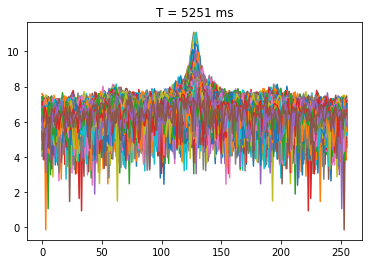

In [5]:
"""
0-5600ms  pure breath

16400-19999ms pure breath

12/18 sensor side+display side　一直線上(left right二本　振動子につくとついていない方)のfftを見たい 
まず直線上で決着付ける　振動が見えるなら，画像全体fftを見る


"""
xmin = 0
xmax = 255
ymin =0
ymax =251
tmin = 5000
tmax = 10000

# Initialize a progess bar
progress = IntProgress()
progress.max = tmax - tmin
progress.description = '(Init)'
display(progress)




for t in range(tmin,tmax):
    for y in range(ymin,ymax):#y軸
        for x in range(xmin,xmax):#x軸
            Z[y-ymin][x-xmin] = f(x,y,t) - f(x,y,0)
    Z_array = np.array(Z)# turn list into array
    h,w=Z_array.shape  #h、wにGのサイズを代入
    fftsize=max(h,w)  #フーリエ変換を行う際の行列のサイズを決定
    z_fourier=sfft.fftshift(sfft.fft2(Z_array,(fftsize,fftsize)))#Gを高速フーリエ変換
    plt.plot(np.log(np.abs(z_fourier)))
    plt.title("T = %s ms"% (t))
             
    #plt.savefig("//FS1//Maedalab//home//junjie-hua//wave//fourD_sensor//rawdata//20191101//Captures//animation//color_map//test3_sensor//narrow//" + str(t) + ".png")
    plt.savefig("C://Users//huaju//Documents//data//fourD_sensor//20191101//Captures//animation//color_map//test1_belly//breath//" + str(t) + ".png")
    #plt.show()
    plt. close()
    progress.value += 1
    progress.description = '%s'%(t)



progress.description = '(Done)'







"""
A=np.ones((fftsize,fftsize))  #ノイズ成分を除去するためのフィルタを作成
A[350:,:]=0#スペクトルより（350～,　）成分を除去
A[:250,:]=0  #スペクトルより（～250,　）成分を除去
A[:,:250]=0  #スペクトルより（　,～250）成分を除去
A[:,350:]=0  #スペクトルより（　,350～）成分を除去

G2=np.uint8(np.abs(sfft.ifft2(sfft.fftshift(z*A))))
plt.imshow(G2[:h,:w],cmap='gray')
plt.show()
"""
